In [1]:
#import packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Hyperparameters

#need to try different values of hyperparrameters
SEQ_LEN = 20
BATCH_SIZE = 32
HIDDEN_SIZE = 64
N_EPOCHS = 50
LEARNING_RATE = 0.001
NUM_LAYERS = 1


In [2]:
#reading and splitting of data

df = pd.read_csv("HistoricalData_1744030076399.csv")
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df = df.sort_values("Date")
df_filtered = df[(df["Date"].dt.year >= 2020) & (df["Date"].dt.year <= 2024)].reset_index(drop=True)

features = ["Close/Last", "Open", "High", "Low"]

#Values normalized between 0 and 1
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_filtered[features])

#If particular features are mort important we can choose to weight them
#scaled_weighted = scaled * np.array([w1, w2, w3, w4, w5])

#create sequences aligns all the data
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len][0])  # Predict Close/Last
    return np.array(X), np.array(y)


X, y = create_sequences(scaled, SEQ_LEN)
dates = df_filtered["Date"][SEQ_LEN:].reset_index(drop=True)


#define test and train sets then reshape data
train_idx = dates.dt.year <= 2023
test_idx = dates.dt.year == 2024

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=BATCH_SIZE, shuffle=True)


In [3]:
#definitions of models

#standard RNN, not so great with long term memory
class StockRNN(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

#LSTM, better with long term memory
class StockLSTM(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

#GRU, less parameters
class StockGRU(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])


#we could choose to add in dropout options

In [4]:
# Choose model
model = StockGRU(input_size=4, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
# model = StockLSTM(input_size=4, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
# model = StockRNN(input_size=4, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)

#would be good to try different loss functions
loss_fn = nn.MSELoss()

#could try different optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#empty vector for training losses
train_losses = []

# Training
for epoch in range(N_EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)



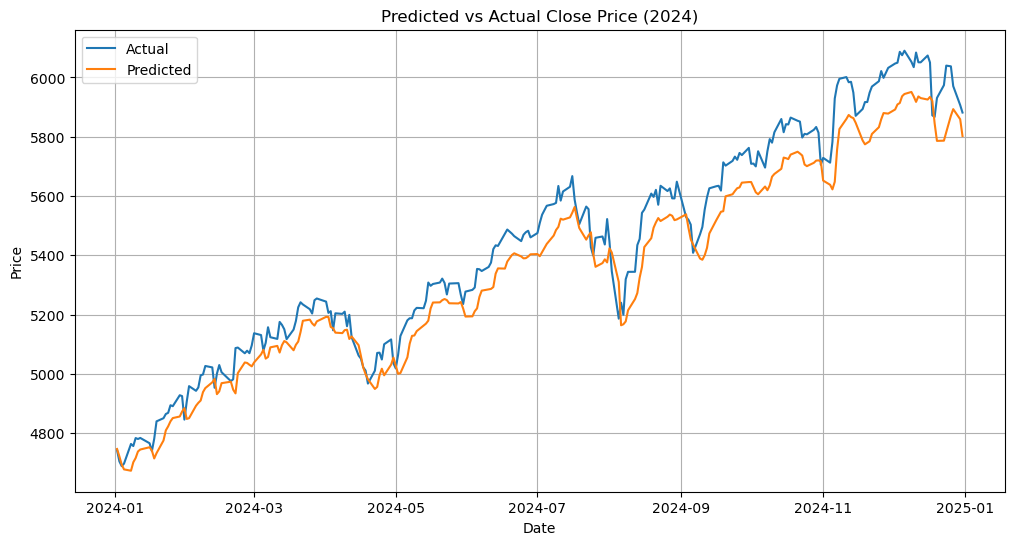

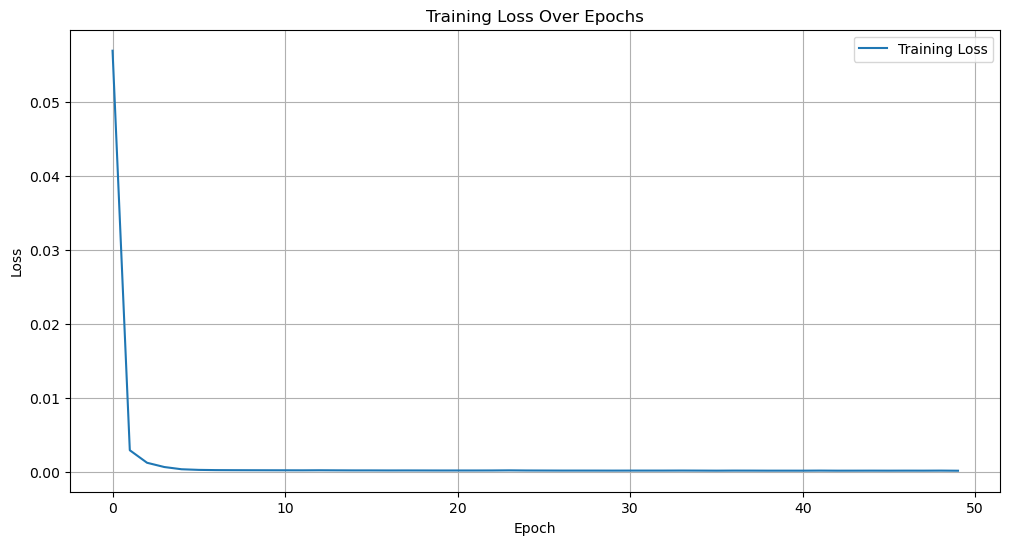

In [5]:
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze().numpy()
    y_actual = y_test_tensor.squeeze().numpy()

# Reverse the scaling back to origninal values
y_pred_unscaled = scaler.inverse_transform(np.column_stack([y_pred, np.zeros((len(y_pred), 3))]))[:, 0]
y_actual_unscaled = scaler.inverse_transform(np.column_stack([y_actual, np.zeros((len(y_actual), 3))]))[:, 0]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dates[test_idx].values, y_actual_unscaled, label="Actual")
plt.plot(dates[test_idx].values, y_pred_unscaled, label="Predicted")
plt.title("Predicted vs Actual Close Price (2024)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()
